#### Setup Section

In [68]:
#Settings
PAIRED=True
num_principal_components = 500 # (aka r, the number of principal components)

In [69]:
#Imports
from rp import *
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import lin_im2im.pca
import icecream
import torch
import torch.nn as nn
import torchvision
import PyTorchOT.ot_pytorch as ot_pytorch
%config InlineBackend.figure_format='retina'
device=torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
sys.path.append(path_join(get_current_directory(),'lin_im2im'))

In [70]:
#Get the images from Domain B (aka X_B, the target domain)
num_images=20000
image_size=(64,64)
image_folder_B='data/celeba/img_align_celeba'
images_B_paths=get_all_paths(image_folder_B)
images_B_path_indices=random_batch(range(len(images_B_paths)),num_images)
images_B=load_images(gather(images_B_paths,images_B_path_indices),strict=False,show_progress=False,use_cache=True)
images_B=[cv_resize_image(image,image_size) for image in images_B]
images_B=[as_rgb_image(as_float_image(image)) for image in images_B]
images_B=as_numpy_array(images_B)

In [71]:
#Get the images from Domain A (AKA X_A, the source domain)
if PAIRED:
    images_A=images_B.copy()
else:
    images_A_paths=images_B_paths
    images_A_path_indices=random_batch(list(   set(range(len(images_A_paths)))   -   set(images_B_path_indices)    ),num_images)
    assert not len(set(images_A_path_indices)&set(images_B_path_indices)) , 'There should be no images in common between A and B if not PAIRED'
    images_A=load_images(gather(images_A_paths,images_A_path_indices),strict=False,show_progress=False,use_cache=True)
    images_A=[cv_resize_image(image,image_size) for image in images_A]
    images_A=[as_rgb_image(as_float_image(image)) for image in images_A]
    images_A=as_numpy_array(images_A)
    
images_A=as_numpy_array([as_rgb_image(as_grayscale_image(image)) for image in images_A])

In [72]:
#Although not technically nessecary for this algorithm to run, it's easier to read code when both domains have the same number of images
num_images = min(len(images_A),len(images_B))
images_A=images_A[:num_images]
images_B=images_B[:num_images]

In [73]:
assert images_A[0].shape==images_B[0].shape, 'All images should be the same size'
image_height,image_width,image_num_channels=images_A.shape[1:]
image_dimensionality=image_height*image_width*image_num_channels # (aka d, the dimensionality of the input images when turned to vectors)

In [74]:
def image_to_vector(image):
    assert is_image(image)
    return image.reshape(-1)
def vector_to_image(vector):
    return vector.reshape((image_height,image_width,image_num_channels))
def images_to_vectors(images):
    assert isinstance(images,np.ndarray)
    return images.reshape((len(images),-1))
def vectors_to_images(vectors):
    assert isinstance(vectors,np.ndarray)
    return vectors.reshape((len(vectors),image_height,image_width,image_num_channels))
def display_images(images):
    display_image(horizontally_concatenated_images(images))
def display_vectors(vectors):
    display_images(vectors_to_images(vectors))

Image Domain A



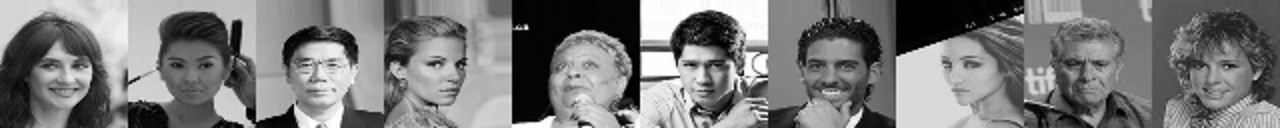

Image Domain B



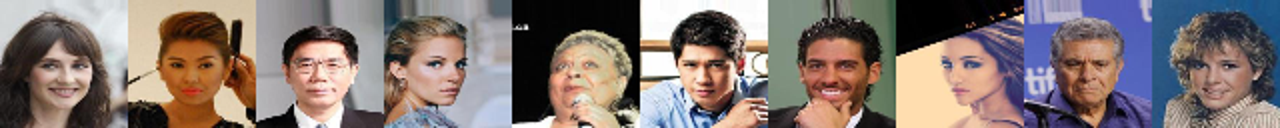

In [75]:
image_display_sample_count=10
image_display_sample_indices=random_batch(range(min(len(images_A),len(images_B))),image_display_sample_count)

print("Image Domain A")
display_images(images_A[image_display_sample_indices])

print("Image Domain B")
display_images(images_B[image_display_sample_indices])

#### Numpy Section

In [76]:
assert num_principal_components <= num_images,'Cannot have more principal components than you do images'
assert num_principal_components <= image_dimensionality,'Cannot have more principal components than there are scalars in an image'
def get_principal_components(vectors):
    assert isinstance(vectors,np.ndarray)
    assert is_a_matrix(vectors)
    # I'm using lin_im2im's author's PCA implementation, becuase it uses GPU acceleration and is orders of magnitude faster than my CPU implementation
    pca=lin_im2im.pca.PCA(num_principal_components) 
    pca.fit(vectors.astype(np.float32))
    return pca.components_

In [77]:
n = num_images
d = image_dimensionality
r = num_principal_components
X_A = images_to_vectors(images_A)
X_A_mean=X_A.mean(0,keepdims=True)
X_A = X_A-X_A_mean

X_B = images_to_vectors(images_B)
X_B_mean=X_B.mean(0,keepdims=True)
X_B = X_B-X_B_mean

assert X_A.shape==X_B.shape==(n,d)

In [78]:
#Please be patient, this can take a while to calculate
W_A = get_principal_components(X_A)
W_B = get_principal_components(X_B)

# W_A,W_B=lin_im2im.pca.aligned_pca(X_A.astype(np.float32),X_B.astype(np.float32),r)
# W_A=W_A.components_
# W_B=W_B.components_

assert W_A.shape==W_B.shape==(r,d)


display_vectors(full_range(X_A[:10]            ))
display_vectors(full_range(X_A[:10]@(W_A.T)@W_A))
display_vectors(full_range(X_B[:10]@(W_B.T)@W_B))
display_vectors(full_range(X_A[:10]            ))

In [79]:
# Z_A=X_A@W_A.T
# Z_B=X_B@W_B.T
# assert Z_A.shape==Z_B.shape==(n,r)

#### LinIm2Im Section

In [80]:
from lin_im2im.ryan_pca_linear_map import PCALinMapping

In [81]:
lin_im2im_model=PCALinMapping(n_components=num_principal_components,
                              pairing='paired' if PAIRED else None,
                              n_iters=10,
                              matching='cyc-nn', #cyc-nn or nn
                              transform_type='orthogonal', #linear, orthogonal
                             )

In [82]:
try:
    lin_im2im_model.fit(X_A.astype(np.float32),X_B.astype(np.float32))
except BaseException as e:
    print_verbose_stack_trace(e)

Got 20000 samples in A and 20000 in B.
PCA A...
PCA B...
Synchronizing...
Using skew-based logic for 373/500 dimensions.
PCA representations:  (20000, 500) (20000, 500) took: 11.778395652770996
Learning orthogonal transformation using paired sets:
took 0.20 sec.



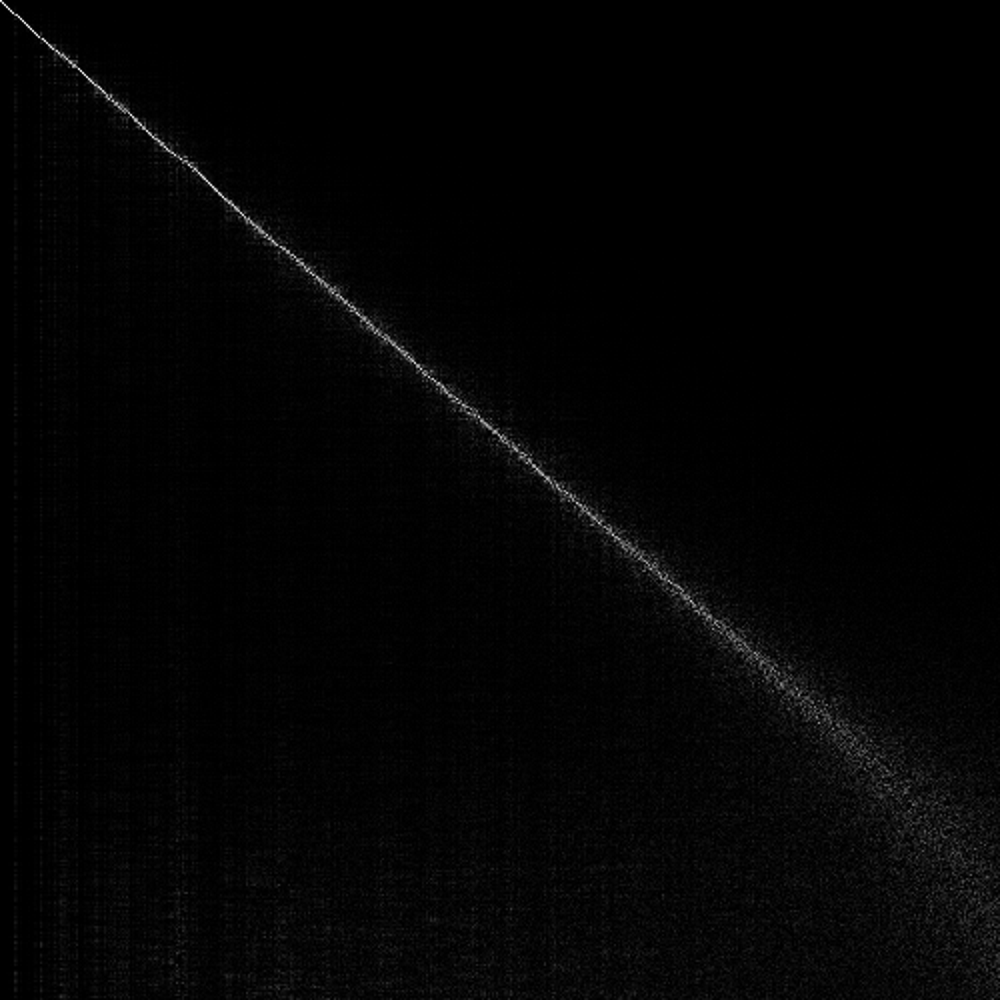

In [83]:
display_image(full_range(np.abs(lin_im2im_model.Q)))

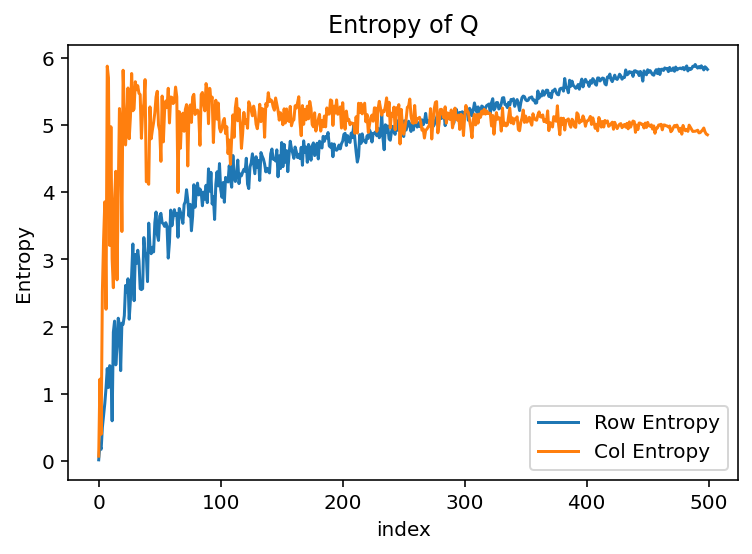

In [84]:
from scipy.stats import entropy
Q_row_entropies=[entropy(np.abs(row)/np.sum(np.abs(row))) for row in lin_im2im_model.Q]
Q_col_entropies=[entropy(np.abs(col)/np.sum(np.abs(col))) for col in lin_im2im_model.Q.T]
pd.DataFrame({'Row Entropy':Q_row_entropies,'Col Entropy':Q_col_entropies,'index':list(range(max(len(Q_row_entropies),len(Q_col_entropies))))}).plot.line(x='index',y=['Row Entropy','Col Entropy'],title='Entropy of Q',ylabel='Entropy',loglog=False);

In [85]:
save_image(full_range(np.log(np.abs(lin_im2im_model.Q))))


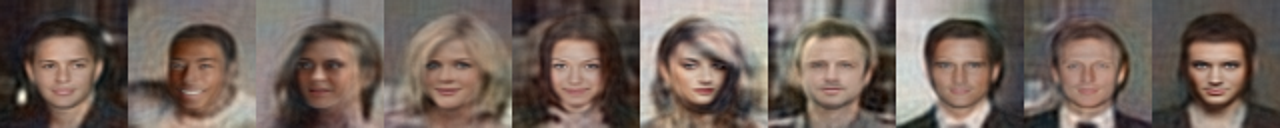

In [91]:
display_vectors(full_range(X_B_mean+lin_im2im_model.transform_a_to_b(X_A[:10],n_comps=500)))


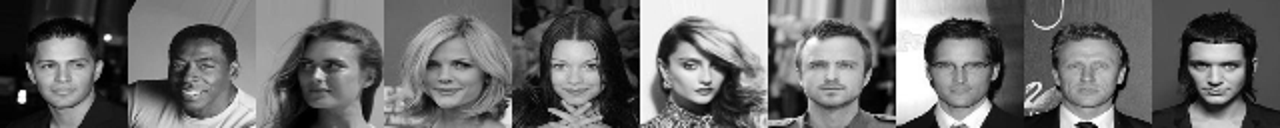

In [87]:
display_vectors(full_range(X_A[:10]+X_A_mean))


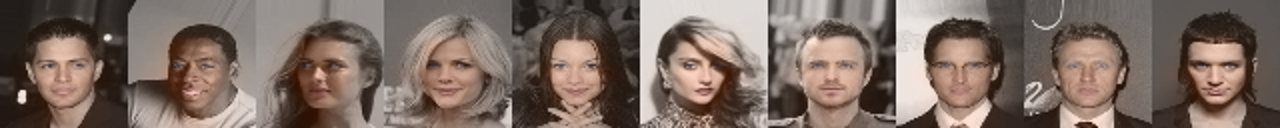


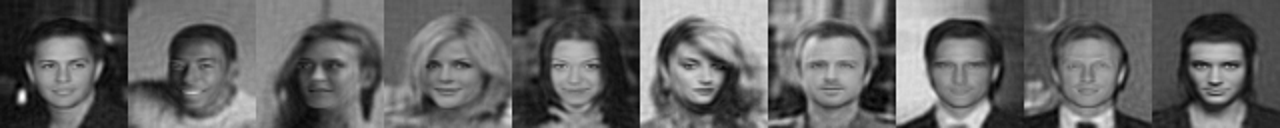


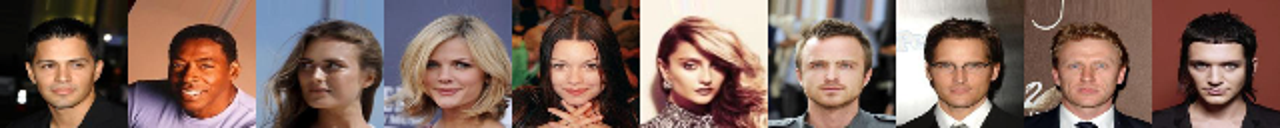


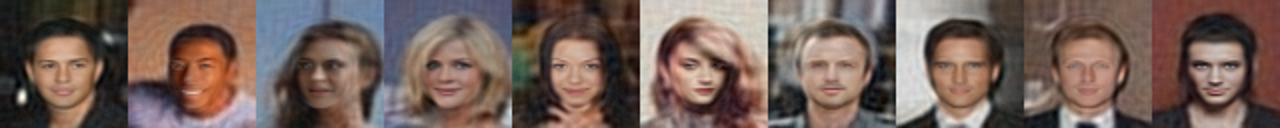

In [88]:
display_vectors(full_range(X_A[:10]+X_B_mean))
display_vectors(full_range(lin_im2im_model.reconstruct_a(X_A[:10])+X_A_mean))
display_vectors(full_range(X_B[:10]+X_B_mean))
display_vectors(full_range(lin_im2im_model.reconstruct_b(X_B[:10])+X_B_mean))